In [166]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import os

In [167]:
from clearml import Task
task = Task.init(project_name='pushup_training', task_name='notebook_training', reuse_last_task_id=False)

ClearML Task: created new task id=c7a0f58a46e84259ae63b9747637a9d7
2022-01-11 15:45:55,903 - clearml.Task - WARNING - Failed auto-detecting task repository: Script file ['ipykernel_launcher', '/tmp/ipykernel_163432/2933350185.py'] could not be found
ClearML results page: https://app.community.clear.ml/projects/b63fc03619e4435ea33998df02b9029c/experiments/c7a0f58a46e84259ae63b9747637a9d7/output/log


In [168]:
params = {
    'selected_keypoints': [2, 5, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],
    'test_size': 0.3,
    'seed': 42,
    'estimator': 'ADA',
    'SVC': {
        'C': 1,
        'kernel': 'linear',
        'gamma': 0.001
    },
    'RF': {
        'n_estimators': 100,
        'max_depth': 2,
        'max_features': 1
    },
    'ADA': {
        'n_estimators': 50,
        'learning_rate': 1.0
    },
    'MLP': {
        'hidden_layer_sizes': (50, 50),
        'learning_rate_init': 0.001
    }
}
task.connect(params)

{'selected_keypoints': [2, 5, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],
 'test_size': 0.3,
 'seed': 42,
 'estimator': 'ADA',
 'SVC': {'C': 1, 'kernel': 'linear', 'gamma': 0.001},
 'RF': {'n_estimators': 100, 'max_depth': 2, 'max_features': 1},
 'ADA': {'n_estimators': 50, 'learning_rate': 1.0},
 'MLP': {'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}}

# Load the data

In [169]:
landmarks = []
landmark_labels = []

images = []
image_labels = []

for csv_name in sorted(glob.glob('../landmarks/**/*.csv')):
    landmarks.append(np.loadtxt(csv_name, delimiter=','))
    landmark_labels.append(os.path.basename(os.path.dirname(csv_name)))

for image_name in sorted(glob.glob('../raw_data/**/*.jpg')):
    images.append(cv2.imread(image_name))
    image_labels.append(os.path.basename(os.path.dirname(image_name)))

landmarks = np.array(landmarks)
landmark_labels = np.array(landmark_labels)
images = np.array(images)
image_labels = np.array(image_labels)

In [170]:
# These are all 33 landmarks, x and y summing up to 66. Augmentation will get rid of the unnessecary landmarks
landmarks.shape

(33, 35, 3)

In [171]:
landmark_labels.shape

(33,)

# Select only important landmarks

In [172]:
# Take only the useful keypoints (14)
selected_keypoints = params['selected_keypoints']
# Keep only keypoints in the list; resulting shape: (-1, 14, 3). 3d coords for each selected keypoint
selected_landmarks = np.take(landmarks, params['selected_keypoints'], axis=1)
# Remove the 3rd dim coordinate and flatten the x and y coords into 1 vector
selected_landmarks = np.array(selected_landmarks)[:, :, :2]
selected_landmarks = selected_landmarks.reshape(selected_landmarks.shape[0], -1)
selected_landmarks.shape

(33, 28)

# Training

In [173]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [174]:
X_train, X_test, y_train, y_test, images_train, images_test, image_labels_train, image_labels_test = train_test_split(selected_landmarks, landmark_labels, images, image_labels, test_size=params['test_size'], random_state=params['seed'])

## Augmentation

In [175]:
import os
if '..' not in os.sys.path:
    os.sys.path.append('..')

from pushup_lockscreen.augmentation import LandMarkAugmentation

In [176]:
def imgaug_to_numpy(landmark_list, np_shape):
    np_landmarks = []
    for list_of_keypoints in landmark_list:
        list_of_np_keypoints = []
        for keypoint in list_of_keypoints:
            np_keypoint = np.array([keypoint.x, keypoint.y])
            list_of_np_keypoints.append(np_keypoint)
        np_landmarks.append(list_of_np_keypoints)
    np_landmarks = np.array(np_landmarks).reshape(-1, np_shape)
    return np_landmarks

In [177]:
augmenter = LandMarkAugmentation(params['seed'])
X_train_augmented = X_train.copy()
X_test_augmented = X_test.copy()
y_train_augmented = y_train.copy()
y_test_augmented = y_test.copy()

# add 10x the amount of original data in augmented versions
for _ in range(10):
    augmented_training_images, augmented_training_landmarks = augmenter.get_augmented_batch(images_train, X_train.reshape(-1, len(params['selected_keypoints']), 2))
    np.append(images_train, augmented_training_images, axis=0)
    np_landmarks = imgaug_to_numpy(augmented_training_landmarks, X_train.shape[1])
    X_train_augmented = np.append(X_train_augmented, np_landmarks, 0)
    y_train_augmented = np.append(y_train_augmented, y_train)

for _ in range(10):
    augmented_testing_images, augmented_testing_landmarks = augmenter.get_augmented_batch(images_test, X_test.reshape(-1, len(params['selected_keypoints']), 2))
    np.append(images_test, augmented_testing_images, axis=0)
    np_landmarks = imgaug_to_numpy(augmented_testing_landmarks, X_test.shape[1])
    X_test_augmented = np.append(X_test_augmented, np_landmarks, 0)
    y_test_augmented = np.append(y_test_augmented, y_test)

print(f'Training: {X_train_augmented.shape}')
print(f'Testing: {X_test_augmented.shape}')
# augmented_testing_images, augmented_testing_landmarks = augmenter.get_augmented_batch(images_test, X_test.reshape(-1, len(selected_keypoints), 2))

Training: (253, 28)
Testing: (110, 28)


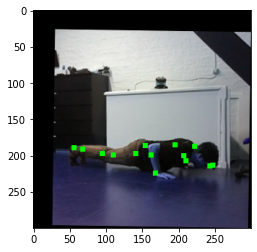

In [178]:
keypoint_image = augmented_training_landmarks[0].draw_on_image(augmented_training_images[0], size=7)
plt.imshow(keypoint_image)
plt.show()

## Standarizing data

In [179]:
# Normalize the landmarks of course
scaler = StandardScaler()
# Only fit the scaler on training data! Otherwise knowledge of test data will leak into training set
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [180]:
y_train_augmented.shape

(253,)

In [181]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

## Training

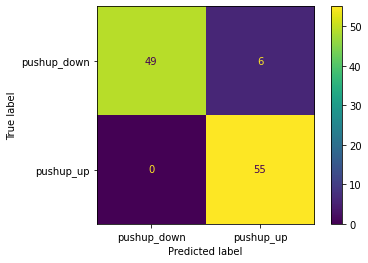

In [182]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

if params['estimator'] == 'SVC':
    model = SVC(**params['SVC'], random_state=params['seed'])
if params['estimator'] == 'RF':
    model = RandomForestClassifier(**params['RF'], random_state=params['seed'])
if params['estimator'] == 'ADA':
    model = AdaBoostClassifier(**params['ADA'], random_state=params['seed'])
if params['estimator'] == 'MLP':
    model = MLPClassifier(**params['MLP'], random_state=params['seed'])

model.fit(X_train_augmented, y_train_augmented)
task.get_logger().report_scalar(params['estimator'], 'ROC AUC Test', roc_auc_score(le.transform(y_test_augmented), le.transform(model.predict(X_test_augmented))), 0)
task.get_logger().report_scalar(params['estimator'], 'ROC AUC Train', roc_auc_score(le.transform(y_train_augmented), le.transform(model.predict(X_train_augmented))), 0)
ConfusionMatrixDisplay.from_estimator(model, X_test_augmented, y_test_augmented)
plt.show()

In [183]:
task.close()

2022-01-11 15:46:01,508 - clearml.Task - INFO - Waiting to finish uploads
2022-01-11 15:46:03,505 - clearml.Task - INFO - Finished uploading
